## Importing Libraries



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Mounting The Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/My Drive/Covid_Dataset/COVID_19_CT_Data')
print(os.getcwd())

/content/drive/My Drive/Covid_Dataset/COVID_19_CT_Data


In [4]:
def load_images(directory):
  img_array = []
  class_name = []

  for dir in os.listdir(directory):
    for file in os.listdir(os.path.join(directory, dir)):
      image_path = os.path.join(directory, dir, file)
      image = cv2.imread(image_path)
      image = np.array(image)
      img_array.append(image)
      class_name.append(dir)

  return np.array(img_array), np.array(class_name)


## Fetching Train Data & Test Data

In [5]:
train_dir = '/content/drive/My Drive/Covid_Dataset/COVID_19_CT_Data/Train'
test_dir = '/content/drive/My Drive/Covid_Dataset/COVID_19_CT_Data/Test'

x_train, y_train = load_images(train_dir)
x_test, y_test = load_images(test_dir)

## Dataset Normalization

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
mean = np.mean(x_train)
std  = np.std(x_train)

In [8]:
x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

## Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Data Shuffling

In [10]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

## CNN Model (VGG 16)

In [11]:
import keras,os
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.applications.vgg16 import VGG16
import numpy as np

In [13]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="sigmoid")) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [14]:
vgg = VGG16(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

## Using Optimizer (Adamax)

In [42]:
from keras.optimizers import Adamax
opt = Adamax(lr=0.001)

model.compile(optimizer='Adamax', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [43]:
import os
os.chdir("/content/drive/My Drive/Covid_Dataset")
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
mc = ModelCheckpoint('covidvgg16.h5', monitor='val_loss', save_best_only=True)
cv = CSVLogger('covidvgg16.csv',append=True)

## Training & Testing


In [44]:
history=model.fit(x_train, y_train, validation_split=(0.2), batch_size=32, callbacks= [mc,cv], epochs=15, verbose=1)

Epoch 1/15
35/35 [==============================] - 135s 4s/step - loss: 0.1558 - accuracy: 0.9546 - val_loss: 0.1877 - val_accuracy: 0.9429
Epoch 2/15
35/35 [==============================] - 134s 4s/step - loss: 0.1464 - accuracy: 0.9683 - val_loss: 0.1834 - val_accuracy: 0.9429
Epoch 3/15
35/35 [==============================] - 134s 4s/step - loss: 0.1439 - accuracy: 0.9659 - val_loss: 0.1845 - val_accuracy: 0.9500
Epoch 4/15
35/35 [==============================] - 134s 4s/step - loss: 0.1320 - accuracy: 0.9681 - val_loss: 0.1744 - val_accuracy: 0.9536
Epoch 5/15
35/35 [==============================] - 134s 4s/step - loss: 0.1248 - accuracy: 0.9668 - val_loss: 0.1787 - val_accuracy: 0.9536
Epoch 6/15
35/35 [==============================] - 134s 4s/step - loss: 0.1294 - accuracy: 0.9677 - val_loss: 0.1670 - val_accuracy: 0.9500
Epoch 7/15
35/35 [==============================] - 134s 4s/step - loss: 0.1152 - accuracy: 0.9722 - val_loss: 0.1643 - val_accuracy: 0.9536
Epoch 8/15
35

## Model Evaluation

In [45]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

19/19 [==============================] - 56s 3s/step - loss: 1.0410 - accuracy: 0.6263
1.0410441160202026
0.626279890537262


## Loss and Accuracy Curves

In [46]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

### Loss Vs Epoch

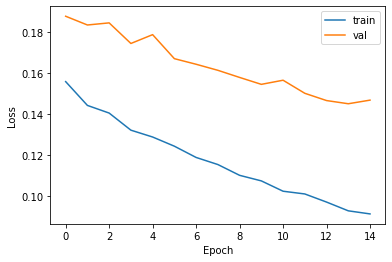

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

### Accuracy Vs Epoch

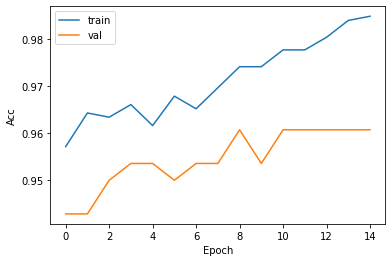

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

## Results


In [49]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['COVID', 'NON COVID']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

       COVID       0.77      0.39      0.52       302
   NON COVID       0.58      0.88      0.69       284

    accuracy                           0.63       586
   macro avg       0.67      0.63      0.61       586
weighted avg       0.68      0.63      0.60       586



## Confusion Matrix

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[118 184]
 [ 35 249]]


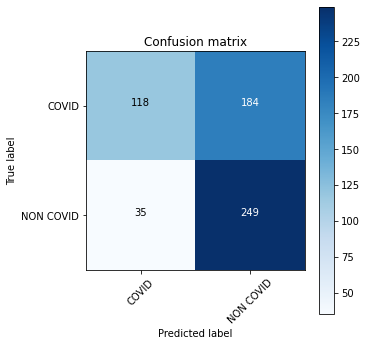

In [51]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')